# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

In [1]:
!python --version

Python 3.7.4


In [2]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('assets/portfolio.json', orient='records', lines=True)
profile = pd.read_json('assets/profile.json', orient='records', lines=True)
transcript = pd.read_json('assets/transcript.json', orient='records', lines=True)

## Portfolio

Firstly, let's take a look at the portfolio data

In [69]:
portfolio.set_index('id', inplace=True)


,reward,channels,difficulty,duration,offer_type
id,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo


Things that are interesting to us are:

`difficulty`: how much do you need to spend to trigger the reward;

`duration`: maximum time for the user to complete the offer;

`offer_type`: Buy one get one free or just discount

## Offer Types

We are interested in how many different offer types are there. The offer type should be combined with `difficulty`, `duration` and `offer_type`. Here I use `_` to connect the information

We know that there are 10 different offers, and 8 of them are actually coupons (we don't care about informational).

Offer types are our `target data`. The end goal of this project is: given a user profile, output the coupon type we should give the the user.

## Consumer Profile

Secondly, let's take a look at the consumer profile

In [4]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [66]:
profile[profile['age']==118].shape

(2175, 5)

In [6]:
no_income_info = profile[profile.income.isna()]
no_income_info.shape

(2175, 5)

It looks like some user data does not have `gender` and `income` info. Let's drop them for now

In [7]:
cleaned_profile = profile.dropna()

In [8]:
cleaned_profile.shape

(14825, 5)

## Question

Should we drop the `NaN` data?

## Transcript

Finally, let's dive into the transcript data

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [11]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

We need to clean up the `value` column, currently it is formated as key-value pairs, let's unpack them into the real value

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
key_value_pairs = transcript.value.tolist()

In [16]:
values = []
for kv in key_value_pairs:
    values.append(list(kv.values())[0])
    
transcript['offer_id'] = values

In [17]:
transcript = transcript.drop(['value'], axis=1)

In [18]:
transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


## Analyze trend for consumers

We will use the `cleaned_profile` as our user dataset

In [19]:
transactions = transcript[transcript['event'] == 'transaction']
transactions.head()

,person,event,time,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [20]:
consumer_trend = transactions.groupby(['person', 'time']).offer_id.sum()

In [21]:
consumer_trend = consumer_trend.reset_index()
consumer_trend.head()

,person,time,offer_id
0,0009655768c64bdeb2e877511632db8f,228,22.16
1,0009655768c64bdeb2e877511632db8f,414,8.57
2,0009655768c64bdeb2e877511632db8f,528,14.11
3,0009655768c64bdeb2e877511632db8f,552,13.56
4,0009655768c64bdeb2e877511632db8f,576,10.27


In [22]:
import numpy as np

consumer_trend_dict = {time: np.zeros(consumer_trend.person.unique().shape[0]) for time in transcript.time.unique()}

consumer_trend_dict['person'] = consumer_trend.person.unique()

consumer_trend_df = pd.DataFrame(consumer_trend_dict)

consumer_trend_df.set_index('person', inplace=True)

consumer_trend_df.head()

,0,6,12,18,24,30,36,42,48,54,...,660,666,672,678,684,690,696,702,708,714
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
for index, row in consumer_trend.iterrows():
    consumer_trend_df.loc[row['person']][row['time']] = row['offer_id']

In [24]:
# consumer_trend_df.to_csv('out/consumer_trend.csv')

consumer_trend_df = pd.read_csv('out/consumer_trend.csv')

In [25]:
consumer_trend_df.set_index('person', inplace=True)

In [26]:
consumer_trend_day_df = pd.DataFrame(index=consumer_trend_df.index)

In [27]:
consumer_trend_df.index

Index(['0009655768c64bdeb2e877511632db8f', '00116118485d4dfda04fdbaba9a87b5c',
       '0011e0d4e6b944f998e987f904e8c1e5', '0020c2b971eb4e9188eac86d93036a77',
       '0020ccbbb6d84e358d3414a3ff76cffd', '003d66b6608740288d6cc97a6903f4f0',
       '00426fe3ffde4c6b9cb9ad6d077a13ea', '004b041fbfe44859945daa2c7f79ee64',
       '004c5799adbf42868b9cff0396190900', '005500a7188546ff8a767329a2f7c76a',
       ...
       'ffeaa02452ef451082a0361c3ca62ef5', 'ffecb1f8543f4bf7bade023de366d6bf',
       'ffede3b700ac41d6a266fa1ba74b4f16', 'fff0f0aac6c547b9b263080f09a5586a',
       'fff29fb549084123bd046dbc5ceb4faa', 'fff3ba4757bd42088c044ca26d73817a',
       'fff7576017104bcc8677a8d63322b5e1', 'fff8957ea8b240a6b5e634b6ee8eafcf',
       'fffad4f4828548d1b5583907f2e9906b', 'ffff82501cea40309d5fdd7edcca4a07'],
      dtype='object', name='person', length=16578)

In [28]:
keys = list(consumer_trend_df.keys())

In [29]:
for i in range(0, len(keys), 4):
    consumer_trend_day_df[i//4] = np.sum(consumer_trend_df[[keys[i], keys[i+1], keys[i+2], keys[i+3]]], axis=1)

In [30]:
consumer_trend_day_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,22.16,...,0.0,0.00,14.11,13.56,10.27,0.00,0.00,12.36,28.16,18.41
00116118485d4dfda04fdbaba9a87b5c,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.00,0.00,0.00,0.0,13.49,0.00,0.0,0.0,0.00,...,0.0,0.00,0.00,0.00,22.05,0.00,23.03,8.96,0.00,0.00
0020c2b971eb4e9188eac86d93036a77,0.0,0.00,49.63,24.39,0.0,0.00,24.31,0.0,0.0,0.00,...,0.0,17.24,33.86,0.00,0.00,0.00,0.00,0.00,0.00,47.43
0020ccbbb6d84e358d3414a3ff76cffd,0.0,16.27,0.00,0.00,0.0,0.00,0.00,0.0,0.0,11.65,...,0.0,0.00,0.00,0.00,0.00,10.32,0.00,0.00,7.47,0.00


In [31]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

user_example = consumer_trend_day_df.loc['0009655768c64bdeb2e877511632db8f']
user_example_2 = consumer_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd']
fig, ax = plt.subplots()
sns.lineplot(user_example.index, user_example.values, ax=ax, label='user 1')
sns.lineplot(user_example_2.index, user_example_2.values, ax=ax, label='user 2')


In [32]:
consumer_trend_day_df.to_csv('out/consumer_trend_day.csv')

## Idea

Add new columns to user profile

Study user pattern



## Question

How do we decide if a user is using a coupon?

In [33]:
cleaned_profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


### User Viewed && Completed Offer

In [34]:
viewed = transcript[transcript['event'] == 'offer viewed']

In [35]:
completed = transcript[transcript['event'] == 'offer completed']

#### Get all unique users in `viewed` and `completed`

In [36]:
users = np.asarray(list(set(viewed.person.unique().tolist() + completed.person.unique().tolist())))

In [37]:
viewed_trend_dict = {time: np.asarray(['' for i in range(users.shape[0])], dtype=str) for time in transcript.time.unique()}

viewed_trend_dict['person'] = users

viewed_trend = pd.DataFrame(viewed_trend_dict)

viewed_trend.set_index('person', inplace=True)

viewed_trend.head()

,0,6,12,18,24,30,36,42,48,54,...,660,666,672,678,684,690,696,702,708,714
person,,,,,,,,,,,,,,,,,,,,,
7366bef4c288476dab78b09a33d0e692,,,,,,,,,,,...,,,,,,,,,,
b854f7297f9e4ecb9d02845941b87479,,,,,,,,,,,...,,,,,,,,,,
b912b714bf5e40609f6ff25a9a542a9c,,,,,,,,,,,...,,,,,,,,,,
46b3c686bbbd4495940b4da488e10ed6,,,,,,,,,,,...,,,,,,,,,,
a14d4f2ec359464f8d4aeac17b755903,,,,,,,,,,,...,,,,,,,,,,


In [38]:
for index, row in viewed.iterrows():
    viewed_trend.loc[row['person']][row['time']] = row['offer_id']

In [39]:
viewed_trend.head()

,0,6,12,18,24,30,36,42,48,54,...,660,666,672,678,684,690,696,702,708,714
person,,,,,,,,,,,,,,,,,,,,,
7366bef4c288476dab78b09a33d0e692,,,,,,,,,,,...,,,,,,,,,,
b854f7297f9e4ecb9d02845941b87479,,,,,,,,,,ae264e3637204a6fb9bb56bc8210ddfd,...,,,,,,,,,,
b912b714bf5e40609f6ff25a9a542a9c,2906b810c7d4411798c6938adc9daaa5,,,,,,,,,,...,,,,,,,,,,
46b3c686bbbd4495940b4da488e10ed6,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,,,,,,...,,,,,,,,,,
a14d4f2ec359464f8d4aeac17b755903,,,,,,,,,,,...,,,,,,,,,,


In [70]:
viewed_trend_day_df = pd.DataFrame(index=viewed_trend.index)
keys = list(viewed_trend.columns)
for i in range(0, len(keys), 4):
    viewed_trend_day_df[i//4] = ''
    for j in range(0, 4):
        viewed_trend_day_df[i//4] += viewed_trend[keys[i+j]]
        viewed_trend_day_df[i//4] += '_'

In [73]:
for col in viewed_trend_day_df.columns:
    for row in viewed_trend_day_df.index:
        temp = [item for item in viewed_trend_day_df.loc[row][col].split('_') if len(item) > 0] 
        
        if len(temp) > 1:
            print('_'.join(temp))
            print(row, col)
            
        viewed_trend_day_df.at[row, col] = '_'.join(temp)

In [74]:
viewed_trend_day_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
person,,,,,,,,,,,,,,,,,,,,,
7366bef4c288476dab78b09a33d0e692,,,,,,,,4d5c57ea9a6940dd891ad53e9dbe8da0,,,...,,,,,,,,,,
b854f7297f9e4ecb9d02845941b87479,,,ae264e3637204a6fb9bb56bc8210ddfd,,,,,,,,...,,,,,,,,,,
b912b714bf5e40609f6ff25a9a542a9c,2906b810c7d4411798c6938adc9daaa5,,,,,,,,,,...,,,,,,,,,,
46b3c686bbbd4495940b4da488e10ed6,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,,,,,,,...,,,,,ae264e3637204a6fb9bb56bc8210ddfd,,,,,
a14d4f2ec359464f8d4aeac17b755903,,,,,,,,fafdcd668e3743c1bb461111dcafc2a4,,,...,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,ae264e3637204a6fb9bb56bc8210ddfd,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f4e0715b897c480e9cb7b72cec1a8607,,,,,,,,,,,...,,,,,,,,,,
da72743f0fd04812a1b9334b0b9ad403,,,,,,,,,,f19421c1d4aa40978ebb69ca19b0e20d,...,,,,,2298d6c36e964ae4a3e7e9706d1fb8c2,,,,,
a29ea9a53fc747dfb077c3f2ef84f83a,,,,,,,,,,,...,,,,,,,,,,


In [75]:
viewed_trend_day_df.to_csv('out/viewed_trend_day_df.csv')

In [76]:
user_viewed_example = list(viewed_trend_day_df.loc['0009655768c64bdeb2e877511632db8f'])
for i, viewed in enumerate(user_viewed_example):
    if viewed =='':
        user_viewed_example[i] = 0
    else:
        user_viewed_example[i] = 10

        
user_viewed_example_2 = list(viewed_trend_day_df.loc['0020ccbbb6d84e358d3414a3ff76cffd'])
for i, viewed in enumerate(user_viewed_example):
    if viewed =='':
        user_viewed_example_2[i] = 0
    else:
        user_viewed_example_2[i] = 10

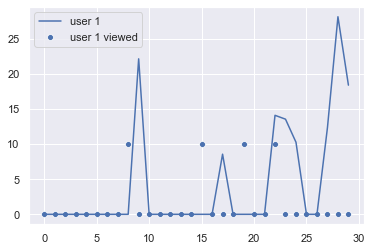

In [77]:
fig, ax = plt.subplots()
sns.scatterplot(user_example.index, user_viewed_example, ax=ax, label='user 1 viewed')
sns.lineplot(user_example.index, user_example.values, ax=ax, label='user 1')

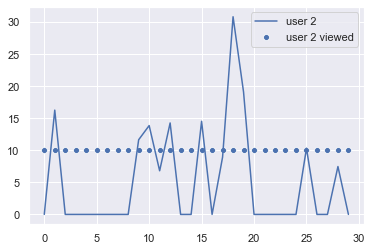

In [78]:
fig, ax = plt.subplots()
sns.scatterplot(user_example_2.index, user_viewed_example_2, ax=ax, label='user 2 viewed')
sns.lineplot(user_example_2.index, user_example_2.values, ax=ax, label='user 2')

In [79]:
# Calculate avarage spending
day_count_spending = consumer_trend_day_df.apply(lambda x: len([y for y in x if y > 0]), axis=1)
average_spending = consumer_trend_day_df.sum(axis=1)/day_count_spending
average_spending.head()

person
0009655768c64bdeb2e877511632db8f    15.950000
00116118485d4dfda04fdbaba9a87b5c     2.045000
0011e0d4e6b944f998e987f904e8c1e5    15.892000
0020c2b971eb4e9188eac86d93036a77    32.810000
0020ccbbb6d84e358d3414a3ff76cffd    14.004545
dtype: float64

We want to know if a coupon has effect on a user, 
We can definitely say user 1 is effective, but we are not so sure about user 2

Definition: if a user spend a lot more than his/her avarage after he/she viewed the offer, we say the offer is effective.
Note: if multiple offer satisfied the requirement, we want to check which one he/she completed, or is the one that is cloesest to completion.

#### TODO

get the completed table done

Then we can get a target table

In [50]:
completed_trend_dict = {time: np.asarray(['' for i in range(users.shape[0])], dtype=str) for time in transcript.time.unique()}

completed_trend_dict['person'] = users

completed_trend = pd.DataFrame(completed_trend_dict)

completed_trend.set_index('person', inplace=True)

for index, row in completed.iterrows():
    completed_trend.loc[row['person']][row['time']] = row['offer_id']

In [51]:
keys = list(completed_trend.columns)
completed_trend_day_df = pd.DataFrame(index=completed_trend.index, dtype=str)

for i in range(0, len(keys), 4):
    completed_trend_day_df[i//4] = ''
    for j in range(0, 4):
        completed_trend_day_df[i//4] += completed_trend[keys[i+j]]
        completed_trend_day_df[i//4] += '_'

In [52]:
for col in completed_trend_day_df.columns:
    for row in completed_trend_day_df.index:
        temp = [item for item in completed_trend_day_df.loc[row][col].split('_') if len(item) > 0] 
        
        if len(temp) > 1:
            print('_'.join(temp))
            print(row, col)
            
        completed_trend_day_df.at[row, col] = '_'.join(temp)


f19421c1d4aa40978ebb69ca19b0e20d_0b1e1539f2cc45b7b9fa7c272da2e1d7
3313c400a5d5467e81e4ce274a0e35a4 7
fafdcd668e3743c1bb461111dcafc2a4_2298d6c36e964ae4a3e7e9706d1fb8c2
86e9d338b85b4177b369fe6b0ad4fed3 7
ae264e3637204a6fb9bb56bc8210ddfd_0b1e1539f2cc45b7b9fa7c272da2e1d7
5042e872687e45fcad0387934dd1a928 7
ae264e3637204a6fb9bb56bc8210ddfd_0b1e1539f2cc45b7b9fa7c272da2e1d7
327cf20d527444aa9a7547f4aec21bb2 7
2298d6c36e964ae4a3e7e9706d1fb8c2_0b1e1539f2cc45b7b9fa7c272da2e1d7
57a0102ba8be4739b05dd3974c5ee2c6 7
f19421c1d4aa40978ebb69ca19b0e20d_0b1e1539f2cc45b7b9fa7c272da2e1d7
10293859aee544a8910d06dc0c62c7e7 7
9b98b8c7a33c4b65b9aebfe6a799e6d9_fafdcd668e3743c1bb461111dcafc2a4
e465b76ab7fe45aab973997ee3412e7e 8
4d5c57ea9a6940dd891ad53e9dbe8da0_0b1e1539f2cc45b7b9fa7c272da2e1d7
dd16b588daf146ec9706cfdd33008c28 8
fafdcd668e3743c1bb461111dcafc2a4_0b1e1539f2cc45b7b9fa7c272da2e1d7
685a085e74d0496a82def0e0962289ab 9
fafdcd668e3743c1bb461111dcafc2a4_2906b810c7d4411798c6938adc9daaa5
ede45209d2ec4d8896efabdb4

In [53]:
completed_trend_day_df.to_csv('out/completed_trend_day_df.csv')

we need to know for a completion, if it is valid. we need to look up the `viewed` table to see if there exists a view on the same coupon id

In [91]:
# build valid
valid_complete_day_df = pd.DataFrame(index=completed_trend_day_df.index)

for col in completed_trend_day_df.columns:
    valid_complete_day_df[col] = ['' for i in range(completed_trend_day_df.shape[0])]

portfolio
valid_complete_day_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
person,,,,,,,,,,,,,,,,,,,,,
7366bef4c288476dab78b09a33d0e692,,,,,,,,,,,...,,,,,,,,,,
b854f7297f9e4ecb9d02845941b87479,,,,,,,,,,,...,,,,,,,,,,
b912b714bf5e40609f6ff25a9a542a9c,,,,,,,,,,,...,,,,,,,,,,
46b3c686bbbd4495940b4da488e10ed6,,,,,,,,,,,...,,,,,,,,,,
a14d4f2ec359464f8d4aeac17b755903,,,,,,,,,,,...,,,,,,,,,,


In [92]:
for col in completed_trend_day_df.columns:
    for row in completed_trend_day_df.index:
        coupon = completed_trend_day_df[col][row]
        if coupon and len(coupon) == 32:
            start = max(col-portfolio['duration'][coupon], 0)
            for day in range(start, col+1):
                if viewed_trend_day_df[day][row] == coupon:
                    valid_complete_day_df.at[row, day] = coupon
        
        elif coupon and len(coupon) > 32:
            coupon_1, coupon_2 = coupon.split("_")  # we know the max coupon complete of a day is 2, see code above
            
            start_1 = max(col-portfolio['duration'][coupon_1], 0)
            for day in range(start_1, col+1):
                if viewed_trend_day_df[day][row] == coupon_1:
                    valid_complete_day_df.at[row, day] = valid_complete_day_df[day][row] + coupon_1       

            start_2 = max(col-portfolio['duration'][coupon_2], 0)
            for day in range(start_2, col+1):
                if viewed_trend_day_df[day][row] == coupon_2:
                    if valid_complete_day_df[day][row] == "":
                        valid_complete_day_df.at[row, day] = coupon_2
                    else:
                        valid_complete_day_df.at[row, day] = valid_complete_day_df[day][row] + "_" + coupon_2
                    

In [93]:
for col in valid_complete_day_df.columns:
    for row in valid_complete_day_df.index:
        if len(valid_complete_day_df[col][row]) > 32:
            print(row, col)
            print(valid_complete_day_df[col][row])
            

d030bccce03a4901a889b54f5930d938 14
0b1e1539f2cc45b7b9fa7c272da2e1d7_0b1e1539f2cc45b7b9fa7c272da2e1d7
cec6feb9507e4fb3b152745e779d5660 16
fafdcd668e3743c1bb461111dcafc2a4_fafdcd668e3743c1bb461111dcafc2a4
a96861615a41443faaf14546c970a012 16
2298d6c36e964ae4a3e7e9706d1fb8c2_2298d6c36e964ae4a3e7e9706d1fb8c2
a96861615a41443faaf14546c970a012 17
2298d6c36e964ae4a3e7e9706d1fb8c2_2298d6c36e964ae4a3e7e9706d1fb8c2
0b6b453772ea4c3a963e92ae2b0817a2 18
fafdcd668e3743c1bb461111dcafc2a4_fafdcd668e3743c1bb461111dcafc2a4
d030bccce03a4901a889b54f5930d938 18
0b1e1539f2cc45b7b9fa7c272da2e1d7_0b1e1539f2cc45b7b9fa7c272da2e1d7
f3934f05d51f47c7a470661cbb774075 19
0b1e1539f2cc45b7b9fa7c272da2e1d7_0b1e1539f2cc45b7b9fa7c272da2e1d7
e5c6a20a9e484510ab9977e353a07d60 21
2298d6c36e964ae4a3e7e9706d1fb8c2_2298d6c36e964ae4a3e7e9706d1fb8c2
08e66f9936c545d4aedf21d35b96baf6 22
0b1e1539f2cc45b7b9fa7c272da2e1d7_0b1e1539f2cc45b7b9fa7c272da2e1d7
c99a06c81f8540b49cb6a66719ea62dc 22
fafdcd668e3743c1bb461111dcafc2a4_fafdcd668e374

In [94]:
valid_complete_day_df.to_csv('out/valid_complete_day_df.csv')

## Create binary classifier for each coupon

In [100]:
target_coupon = pd.DataFrame(index=valid_complete_day_df.index)

for coupon in portfolio.index:
    if portfolio['difficulty'][coupon] != 0:
        target_coupon[coupon] = np.zeros(target_coupon.shape[0], dtype=int)
    
for col in valid_complete_day_df.columns:
    for row in valid_complete_day_df.index:
        coupon = valid_complete_day_df[col][row]
        if coupon != '':
            if len(coupon) == 32:
                target_coupon.at[row, coupon] = 1
            else:
                coupon_1, coupon_2 = coupon.split('_')
                target_coupon.at[row, coupon_1] = 1
                target_coupon.at[row, coupon_2] = 1

np.unique(target_coupon.values)

array([0, 1])

In [101]:
target_coupon.to_csv('out/target_coupon.csv')

## Build target type for each different coupon types

### type A as an example

In [ ]:
type_A_id = '68be06ca386d4c31939f3a4f0e3dd783'

type_A_viewed_df = pd.DataFrame(index=viewed_trend_day_df.index, viewed=np.asarray(0 for ))

### Concept sale increase rate? We can apply this method to each coupon seperately

definition:

if user increases his/her purchase a lot after he/she viewed the coupon, we say this coupon is `effective` to this person

#### Completed overtime by user name

In [76]:
for index, row in completed.iterrows():
    if row['offer_id'] in {'4d5c57ea9a6940dd891ad53e9dbe8da0', 'f19421c1d4aa40978ebb69ca19b0e20'}:
        if viewed_trend.loc[row['person']][row['time']] == row['offer_id']:
            completed_trend.loc[row['person']][row['time']] = row['offer_id']
    elif row['offer_id'] in {'ae264e3637204a6fb9bb56bc8210ddfd', '9b98b8c7a33c4b65b9aebfe6a799e6d9', '0b1e1539f2cc45b7b9fa7c272da2e1d7',
                             '2298d6c36e964ae4a3e7e9706d1fb8c2','fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5'}:
        if viewed_trend.loc[row['person']][row['time']] == row['offer_id']:
            completed_trend.loc[row['person']][row['time']] = row['offer_id']
        elif int(row['time'])-6>=0 and completed_trend.loc[row['person']][int(row['time'])-6] == row['offer_id']:
            completed_trend.loc[row['person']][row['time']] = row['offer_id']

KeyboardInterrupt: 

In [ ]:
completed_trend_day_df = pd.DataFrame(index=completed_trend.index)
keys = list(completed_trend.columns)
for i in range(0, len(keys), 4):
    completed_trend_day_df[i//4] = ''
    for j in range(0, 4):
        completed_trend_day_df[i//4] += completed_trend[keys[i]]
        completed_trend_day_df[i//4] += '_'

In [74]:
completed_trend_day_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
person,,,,,,,,,,,,,,,,,,,,,
f3ea5b7c75bb41cba87ef3195caf2ab4,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
9e784b0f6f3c412db22ad03f7a415f31,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
40baeb85957441709f5184161a22068c,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
b534789609ae405a9023d098f40d4d40,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
3d19526685174baa8bcc3e9a952cab18,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8c843138f8d642da9bec4370e87c38d9,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
2fc2ef210bdd44b1bbebf4f5e809c871,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____
c218177304b94ff0a0953f3ce9867870,____,____,____,____,____,____,____,____,____,____,...,____,____,____,____,____,____,____,____,____,____


## Explaination

When we see an offer is complete, we need to find out within the duration of that offer, if it is viewed.

In [52]:
completed_trend.to_csv('out/completed_trend.csv')

In [53]:
viewed_trend.to_csv('out/viewed_trend.csv')